In [53]:
%matplotlib inline
from IPython.display import display, clear_output
import simpy as sp
from concurrent.futures import ProcessPoolExecutor
import myutils as mu
import time
import datetime as dt
import matplotlib.pyplot as plt
import math
import json as js

plt.rcParams['animation.embed_limit'] = 2**128

In [54]:
MAX_RSSI = -30 # dBm
MIN_RSSI = -120 # dBm
MAX_EIRP = 12  # dBm
ANTENNA_GAIN = 2.5 # dbi
CABLE_LOSS = 0.5 # dBm
TX_POWER = 10 # dbm 
FREQUENCY = 433e6 # Hz
BANDWIDTH = 125e3 # Hz
NOISE_FIGURE = 6 #
SPREADING_FACTOR = 12
SNR_LIMIT = {7: -7.5, 8: -10, 9: -12.5, 10: -15, 11: -17.5, 12: -20} # dB 
PREAMBLE_LENGTH = 8
IMPLICIT_HEADER = 0
CODING_RATE = 1
DATARATE_OPTIMIZE = 0

JOIN_REQUEST = 0
JOIN_ACCEPT = 1
DATA_UPLINK_CONFIRMED = 2
DATA_DOWNLINK_CONFIRMED = 3
DATA_UPLINK_UNCONFIRMED = 4
DATA_DOWNLINK_UNCONFIRMED = 5

RX_WINDOW = 2
G = mu.load_map()

In [55]:
class PacketMetadata():
    def __init__(self, lat, lng, frame, frame_type, lora) -> None:
        self.lat = lat
        self.lng = lng
        self.frame = frame
        self.lora = lora
        self.type = frame_type
        self.gateways = list()
        self.buses = list()

    @property
    def rx_delay(self):
        return 5 if self.type == JOIN_REQUEST else 2
    
    @property
    def time_on_air(self):
        return self.lora.time_on_air(len(self.frame))
    
    def meta_data(self, gateway):
        msg = {
            'id': gateway.ID,
            'rssi': 0,
            'snr': 0,
            'frame': self.frame
        }
        return js.dumps(msg)
    
    def send_uplink(self):
        for gateway in self.lora.gateways:
            distance = mu.ox.distance.great_circle_vec(self.lat, self.lng, gateway.lat, gateway.lng)
            if distance <= self.lora.mean_d:
                self.gateways.append((gateway, distance))
        self.gateways.sort(key=lambda pair: pair[1])
        for gateway in self.gateways:
            yield gateway[0].ul_store.put(self)
    
    def send_downlink(self):
        for bus in self.lora.buses:
            distance = mu.ox.distance.great_circle_vec(self.lat, self.lng, bus.lat, bus.lng)
            if distance <= self.lora.mean_d:
                self.buses.append(bus)
        for bus in self.buses:
            yield bus.dl_store.put(self)

In [56]:
class LoRaWANModel():
    def __init__(self, max_rssi, min_rssi, tx_power, antenna_gain, frequency, bandwidth, cable_loss, noise_figure, spreading_factor) -> None:
        self.mean_rssi = (max_rssi + min_rssi) / 2
        self.min_rssi = min_rssi
        self.max_rssi = max_rssi
        self.tx = tx_power
        self.atn = antenna_gain
        self.freq = frequency
        self.bw = bandwidth
        self.cable = cable_loss
        self.nf = noise_figure
        self.snr_lim = SNR_LIMIT[spreading_factor]
        self.sf = spreading_factor
        self.rx_sens = self.rx_sensitivity
        self.min_d = self.distance(max_rssi) # m
        self.max_d = self.distance(min_rssi) # m
        self.mean_d = self.distance(self.mean_rssi) # m

    @property
    def rx_sensitivity(self):
        return -174 + 10 * math.log(self.bw, 10) + self.nf + self.snr_lim
    
    @property
    def eirp(self):
        return min(self.tx + self.atn - self.cable, MAX_EIRP)
    
    def free_space_path_loss(self, distance):
        return 20 * math.log(distance, 10) + 20 * math.log(self.freq, 10) - 147.55 # dBm
    
    def rssi(self, distance):
        return self.eirp - self.free_space_path_loss(distance) + self.atn - self.cable # dBm
    
    def distance(self, rssi):
        fspl = self.eirp + self.atn - self.cable - rssi
        tmp = fspl + 147.55 - 20 * math.log(self.freq, 10)
        return 10 ** (tmp / 20)
    
    def time_on_air(self, data_len):
        t_sym = 2 ** self.sf
        t_preamble = (PREAMBLE_LENGTH + 4.25) * t_sym
        tmp_a = 8 * data_len - 4 * self.sf + 28 + 16 * CODING_RATE - 20 * IMPLICIT_HEADER
        tmp_b = 4 * (self.sf - 2 * DATARATE_OPTIMIZE)
        tmp_c = math.ceil(tmp_a / tmp_b) * (CODING_RATE + 4)
        tmp = tmp_c if tmp_c > 0 else 0
        pl = 8 + tmp
        t_pl = pl * t_sym
        return t_preamble + t_pl
    
    def setup(self, env):
        self.env = env
        self.ul_store = sp.Store(env)
        self.jr_store = sp.Store(env)
        self.gateways = list()
        self.buses = list()
        self.env.process(self.join_server_process())
        self.env.process(self.network_server_process())

    def process_frame(self, packet):
        for gw in packet.gateways:
            if gw[0].is_available:
                pkt = PacketMetadata(
                    gw[0].lat, 
                    gw[0].lng, 
                    "", 
                    JOIN_ACCEPT if packet.type == JOIN_REQUEST else DATA_UPLINK_UNCONFIRMED, 
                    self.lora)
                yield self.env.timeout(packet.rx_delay)
                yield gw.dl_store.put(pkt)
                break

    def join_server_process(self):
        while True:
            packet = yield self.jr_store.get()
            self.env(self.process_frame(packet))

    def network_server_process(self):
        while True:
            packet = yield self.ul_store.get()
            self.env(self.process_frame(packet))

lora = LoRaWANModel(MAX_RSSI, MIN_RSSI, TX_POWER, ANTENNA_GAIN, FREQUENCY, BANDWIDTH, CABLE_LOSS, NOISE_FIGURE, SPREADING_FACTOR)

In [57]:
class StationModel():
    stations = set()
    def __init__(self, routeId, varId) -> None:
        src = mu.STOPS_FILE_NAME + str(varId)
        api = mu.STOPS_API(id=routeId, varId=varId)
        stops_df = mu.load_data(route=routeId, source=src, api=api)
        stops_df = stops_df[["StopId", "Lat", "Lng"]]
        self.stops_df = stops_df.rename(columns={"StopId":"stop_id", "Lat":"lat", "Lng":"lng"})

        StationModel.stations.update(self.stops_df["stop_id"].tolist())

In [58]:
class GatewayModel():
    def __init__(self, lat, lng, index) -> None:
        self.lat = lat
        self.lng = lng
        self.name = f'gateway{index}'
        self.len = 256

    @property
    def x(self):
        return self.lng

    @property
    def y(self):
        return self.lat
    
    @property
    def is_available(self):
        return self.env.now - self.last_tx > self.off_duty_cycle
    
    def setup(self, env, lora):
        self.env = env
        self.lora = lora
        self.ul_store = sp.Store(env)
        self.dl_store = sp.Store(env)
        lora.gateways.append(self)
        self.env.process(self.loop_process())
        self.last_tx = 0
        self.off_duty_cycle = 0

    def loop_process(self):
        while True:
            rx_packet = yield self.ul_store.get()
            if rx_packet.type == JOIN_REQUEST:
                yield self.lora.jr_store.put(rx_packet)
            else:
                yield self.lora.ul_store.put(rx_packet)
                
            now = self.env.now
            if now - self.last_tx > self.off_duty_cycle and len(self.dl_store.items) > 0:
                tx_packet = yield self.dl_store.get()
                self.off_duty_cycle = tx_packet.time_on_air * 90
                tx_packet.send_downlink()
                self.last_tx = now

In [59]:
class Bus():
    def __init__(self, route, var, id, index, env, lora) -> None:
        self.route = route
        self.start_var = var
        self.id = id
        self.env = env
        self.lora = lora
        self.dl_store = sp.Store(env)
        self.ul_store = sp.Store(env)

        self.dev_eui = 18374685380159995904 + index
        self.name = f'test_enddevice{index}'
        self.rx_proc = self.env.process(self.loop_process())
        self.last_tx = 0

        self.lat = 0
        self.lng = 0

    def __str__(self) -> str:
        return f"Bus:{self.route}:{self.start_var}:{self.id}"
    
    def send_join_request(self, lat, lng):
        self.lat = lat
        self.lng = lng
        frame = "80C02301260021000266EEA76CCE0C1BBC7A36F69F"
        yield self.ul_store.put(PacketMetadata(lat, lng, frame, JOIN_REQUEST, self.lora))

    def send_unconfirmed_uplink(self, lat, lng):
        self.lat = lat
        self.lng = lng
        frame = "80C02301260021000266EEA76CCE0C1BBC7A36F69F"
        yield self.ul_store.put(PacketMetadata(lat, lng, frame, DATA_DOWNLINK_UNCONFIRMED, self.lora))

    def send_confirmed_uplink(self, lat, lng):
        self.lat = lat
        self.lng = lng
        frame = "80C02301260021000266EEA76CCE0C1BBC7A36F69F"
        yield self.ul_store.put(PacketMetadata(lat, lng, frame, DATA_DOWNLINK_CONFIRMED, self.lora))
    
    def loop_process(self):
        while True:
            packet = yield self.ul_store.get()
            now = self.env.now
            timeout = now - self.last_tx - packet.time_on_air * 90
            yield self.env.timeout(timeout if timeout > 0 else 0)
            packet.send_uplink()
            self.last_tx = self.env.now
            
            yield self.env.timeout(packet.rx_delay)
            
            timeout = 0
            while len(self.dl_store.items):
                timeout += 1
                yield self.env.timeout(timeout)
                rx_pkt = yield self.dl_store.get()
            self.dl_store.items.clear()

In [60]:
class BusModel():
    X = dict()
    Y = dict()

    def __init__(self, id) -> None:
        self.route = id
        timetables_df = mu.load_data(route=id, source=mu.TIMETABLE_FILE_NAME, api=mu.TIMETABLE_API(id))
        
        self.vars = list()
        self.stations = dict()
        self.paths_df = dict()
        self.trips_df = dict()
        self.bus_num = dict()
        for i, row in timetables_df.iterrows():
            varId = row["RouteVarId"]
            self.bus_num[varId] = 0
            self.vars.append(varId)
    
            self.stations[varId] = StationModel(routeId=id, varId=varId)

            src = mu.PATHS_FILE_NAME + str(varId)
            self.paths_df[varId] = mu.load_data(route=id, source=src, api=mu.PATHS_API(id=id, varId=varId))
        
            tripId = row["TimeTableId"]
            src = mu.TRIPS_FILE_NAME + str(varId)
            trip_df = mu.load_data(route=id, source=src, api=mu.TRIPS_API(id=id, tripId=tripId))
            trip_df = trip_df[["StartTime", "EndTime"]]
            self.trips_df[varId] = trip_df.rename(columns={"StartTime":"start", "EndTime":"end"})
            self.trips_df[varId] = self.trips_df[varId].applymap(lambda t: time.strptime(t,'%H:%M'))
            self.trips_df[varId] = self.trips_df[varId].applymap(lambda t: dt.timedelta(hours=t.tm_hour,minutes=t.tm_min,seconds=t.tm_sec).total_seconds())

    def prepare_path(self):
        is_used_local = False

        for varId in self.vars:
            source = mu.DF_FILE_NAME + str(varId)
            try:
                eval_columns = ["edge", "route"]
                self.paths_df[varId] = mu.load_path_data(route=self.route, source=source, eval_columns=eval_columns)
                is_used_local = True
            except FileNotFoundError:
                break

        if is_used_local: return

        with ProcessPoolExecutor() as executor:
            params = [(varId, self.paths_df[varId], self.stations[varId].stops_df, G) for varId in self.vars]
            results = executor.map(mu.get_routes_from_paths, params)
            for result in results:
                id, df = result
                self.paths_df[id] = df
                mu.save_path_data(route=self.route, var=id, df=df)

    def prepare_graph(self):
        self.station_num = {var: self.paths_df[var][self.paths_df[var]["station"]].shape[0] for var in self.vars}
        self.station_max = self.station_num[max(self.station_num, key=lambda id: self.station_num[id])]
        
        self.path_count = {var: self.paths_df[var].shape[0] for var in self.vars}
        self.path_max = self.path_count[max(self.path_count, key=lambda id: self.path_count[id])]
        
        self.x = {var: self.paths_df[var].apply(lambda path: G.nodes[path["edge"][0]]["x"], axis="columns") for var in self.vars}
        self.max_x = self.x[max(self.x, key=lambda id: self.x[id].max())].max()
        self.min_x = self.x[min(self.x, key=lambda id: self.x[id].min())].min()

        self.y = {var: self.paths_df[var].apply(lambda path: G.nodes[path["edge"][0]]["y"], axis="columns") for var in self.vars}
        self.max_y = self.y[max(self.y, key=lambda id: self.y[id].max())].max()
        self.min_y = self.y[min(self.y, key=lambda id: self.y[id].min())].min()

        self.travel_time = {var: self.paths_df[var]["travel_times"].sum() for var in self.vars}

    def setup(self, env, oneday, lora):
        BusModel.X[self.route] = dict()
        BusModel.Y[self.route] = dict()

        self.env = env
        self.oneday = oneday
        for var in self.vars:
            station = self.stations[var].stops_df
            station["node"] = mu.ox.nearest_nodes(G, X=station["lng"], Y=station["lat"])
                
        bus_nums = {
            var: self.trips_df[var][
                    self.trips_df[var].apply(lambda trip: trip["start"] - self.trips_df[var].loc[0, "start"], axis="columns") < self.travel_time[var]
                ].shape[0]
            for var in self.vars
        }
        bus_num = bus_nums[max(bus_nums, key=lambda x: bus_nums[x])] * 2
        self.buses = sp.FilterStore(env, capacity=bus_num)
        for var in self.vars:
            for i in range(bus_num):
                bus = Bus(self.route, var, i, len(self.buses.items), env, lora)
                self.buses.put(bus)
                lora.buses.append(bus)

    def cleanup(self):
        for bus in self.buses:
            bus.cleanup()

    @classmethod
    def get_coord(cls):
        X_values = dict()
        Y_values = dict()
        for route in cls.X:
            X_values[route] = [cls.X[route][id] for id in cls.X[route]]
            Y_values[route] = [cls.Y[route][id] for id in cls.Y[route]]
        return X_values, Y_values

    def start_route(self, var, bus):
        for i, path in self.paths_df[var].iterrows():
            if path["station"]:
                # station = self.stations[var].stops_df
                # stop_id = station.loc[station['node'] == path["node"], "stop_id"]
                # print(f"{bus} has arrive at station {stop_id.iloc[0]}")
                pass
            
            BusModel.X[self.route][bus.id] = self.x[var].iloc[i]
            BusModel.Y[self.route][bus.id] = self.y[var].iloc[i]

            yield self.env.timeout(path["travel_times"])
            if i == self.path_count[var] - 1:
                pass

        del BusModel.X[self.route][bus.id]
        del BusModel.Y[self.route][bus.id]
        yield self.buses.put(bus)

    def start_schedule(self, outbound, inbound):
        for _, trip in self.trips_df[outbound].iterrows():
            bus = yield self.buses.get(lambda bus: bus.start_var == outbound)

            spare_time = int(trip["start"]) - (self.env.now % self.oneday)
            if spare_time > 0 : yield self.env.timeout(spare_time)

            bus.start_var = inbound
            self.env.process(self.start_route(outbound, bus))

In [61]:
buses = list()
bus_ids = [70, 54, 51]
for id in bus_ids:
    bus = BusModel(id)
    buses.append(bus)
    bus.prepare_path()
    bus.prepare_graph()

In [62]:
north = 0
south = 0
east = 0
west = 0
padding = 0.04

for i, bus in enumerate(buses):
    if i == 0:
        east = bus.max_x
        west = bus.min_x
        north = bus.max_y
        south = bus.min_y
    else:
        east = max(east, bus.max_x)
        west = min(west, bus.min_x)
        north = max(north, bus.max_y)
        south = min(south, bus.min_y)

padding_ns = (north - south) * padding
padding_ew = (east - west) * padding
bbox = north + padding_ns, south - padding_ns, east + padding_ew, west - padding_ew

trunc_G = mu.ox.truncate.truncate_graph_bbox(G, *bbox)
fig, ax = mu.ox.plot_graph(G=trunc_G, figsize=(18, 18), node_size=0, edge_linewidth=1, show=False, close=True, bbox=bbox)

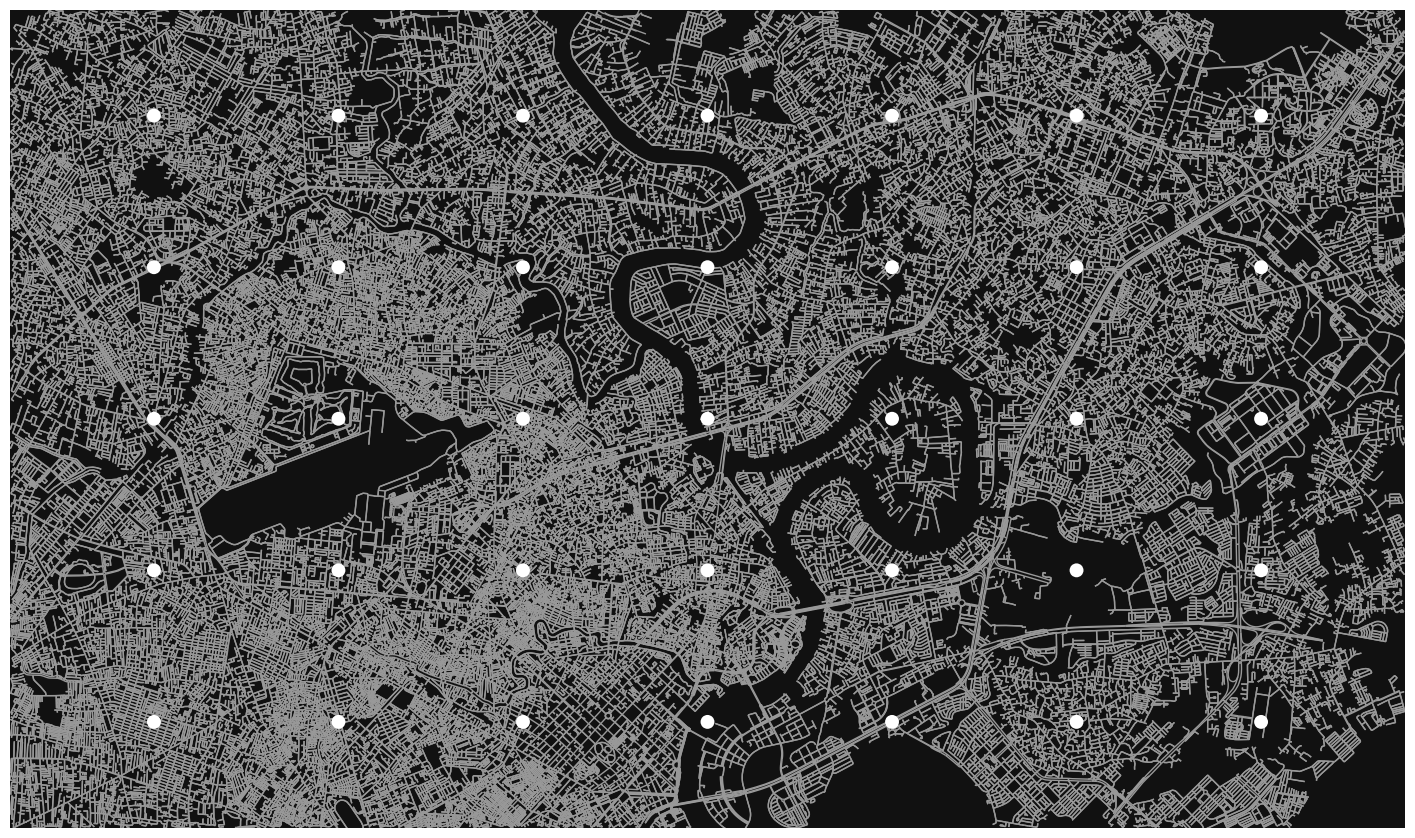

In [63]:
width_distance = mu.ox.distance.great_circle_vec(north, west, north, east) # m
width_vec = mu.ox.distance.euclidean_dist_vec(north, west, north, east) # coords' unit
width_count = int(width_distance / lora.mean_d / 2 + 1) # diameter
width_unit = width_vec / width_count

height_distance = mu.ox.distance.great_circle_vec(north, west, south, west) # m
height_vec = mu.ox.distance.euclidean_dist_vec(north, west, south, west) # coords' unit
height_count = int(height_distance / lora.mean_d / 2 + 1) # diameter
heigth_unit = height_vec / height_count

gateways = list()
for h in range(height_count):
    y = min(north, south) + (h + 0.5) * heigth_unit
    for w in range(width_count):
        x = min(west, east) + (w + 0.5) * width_unit
        node = G.nodes[mu.ox.nearest_nodes(trunc_G, X=x, Y=y)]
        gateways.append(GatewayModel(lat=y, lng=x, index=len(gateways)))

gw_scatter = ax.scatter([gw.x for gw in gateways], [gw.y for gw in gateways], s=100, c="w", alpha=1, edgecolor="none")
display(ax.figure)
gw_scatter.remove()

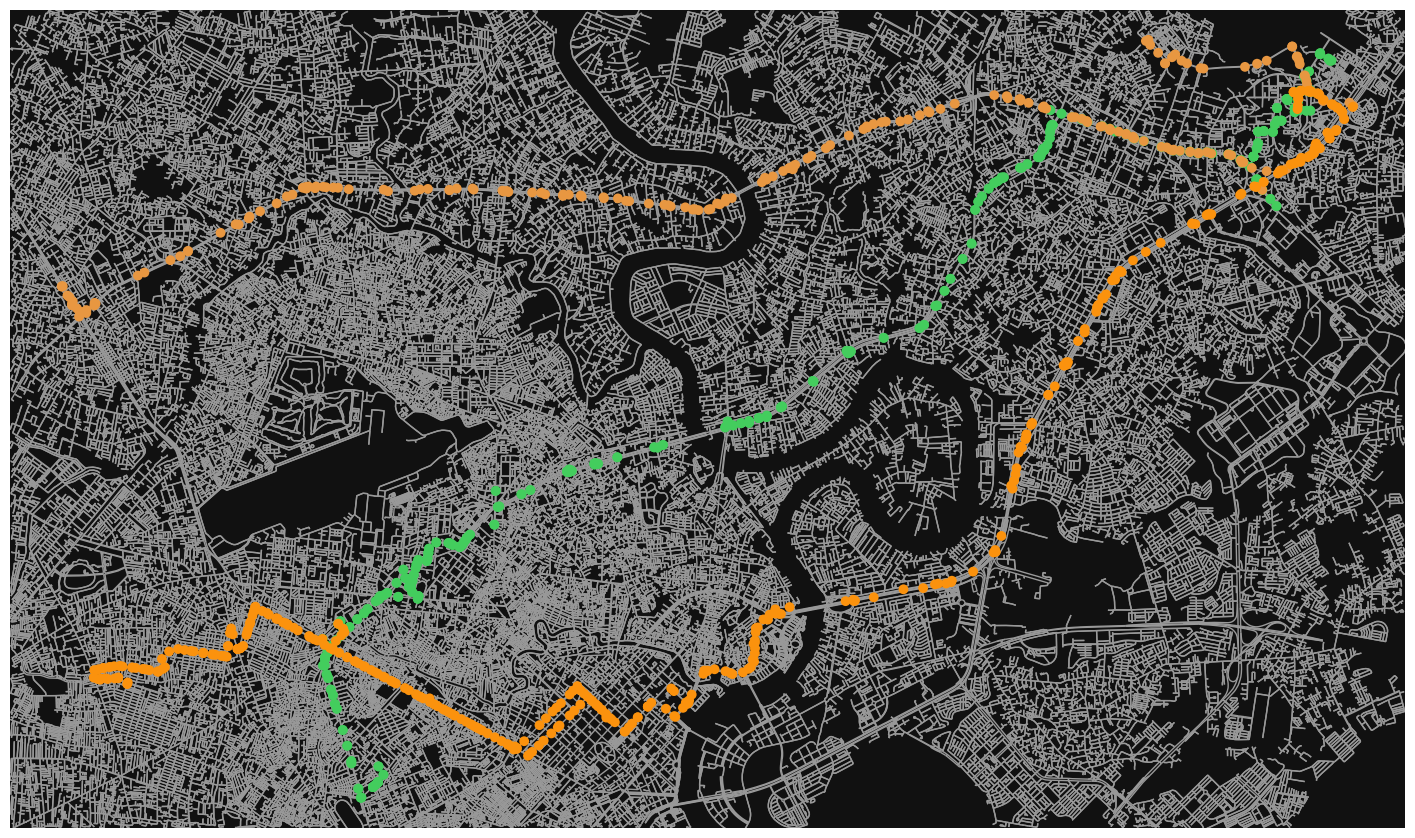

In [64]:
tmp_scatters = list()
for bus in buses:
    r = lambda: mu.rd.randint(0,255)
    color = f"#{r():02x}{r():02x}{r():02x}"
    for var in bus.vars:
        tmp_scatters.append(ax.scatter(bus.x[var], bus.y[var], s=50, c=color, alpha=1, edgecolor="none"))
display(ax.figure)
for tmp in tmp_scatters:
    tmp.remove()
tmp_scatters.clear()

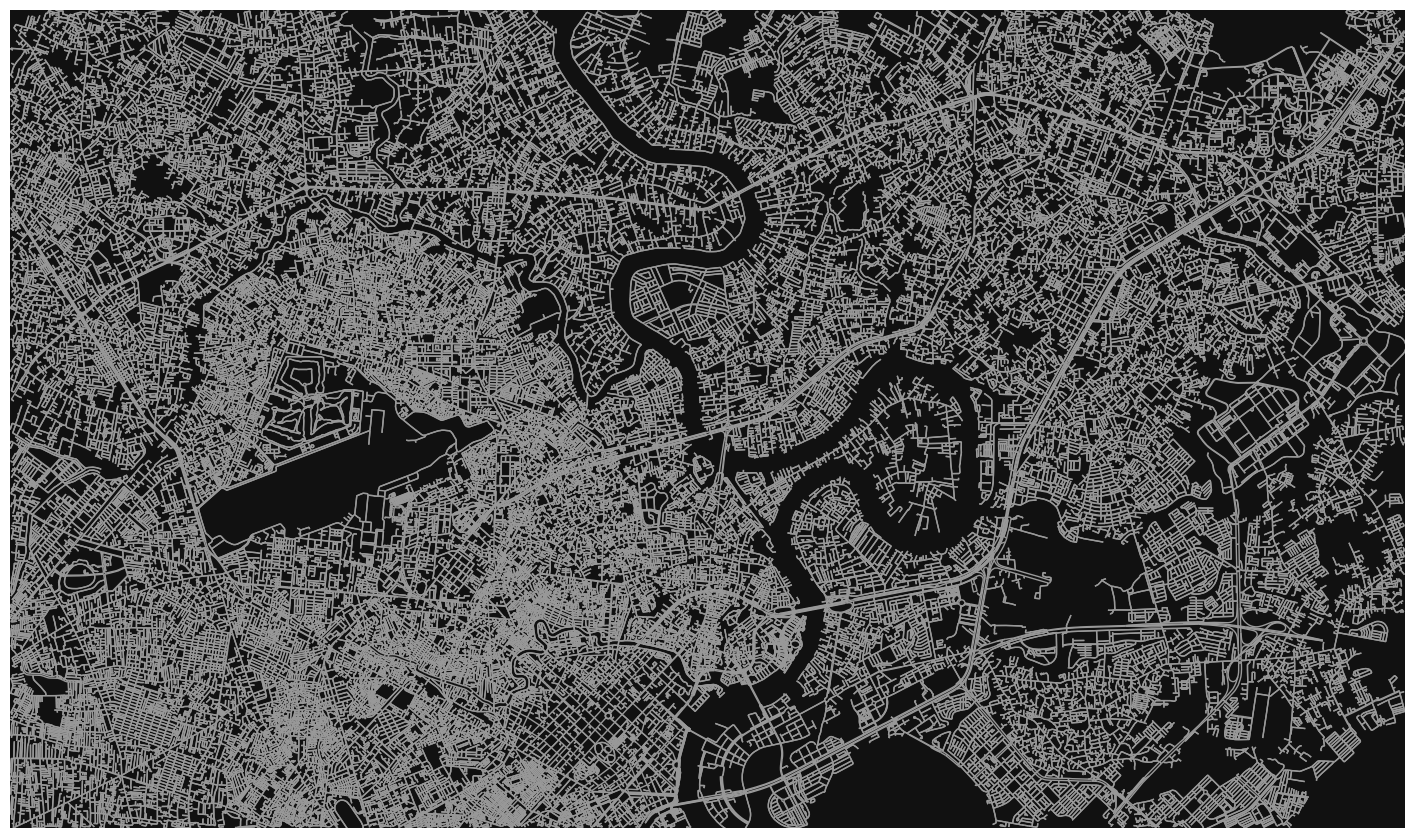

In [65]:
start_time = min([min(trip.iloc[0]["start"] for _, trip in bus.trips_df.items()) for bus in buses])
env = sp.Environment(start_time)
ONE_DAY_IN_SEC = 60*60*24
PLOT_INTERVAL = 60*15
scatters = list()
colors = dict()

def get_random_color():
    r = lambda: mu.rd.randint(0,255)
    color = f"#{r():02x}{r():02x}{r():02x}"
    return color


for bus in bus_ids:
    if bus in colors: continue

    color_set = set([colors[var] for var in colors])
    color = get_random_color()
    while color in color_set:
        color = get_random_color()
    colors[bus] = color


def start_simulation():
    lora.setup(env)

    for bus in buses:
        bus.setup(env, ONE_DAY_IN_SEC, lora)

    for gw in gateways:
        gw.setup(env, lora)

    while True:
        for bus in buses:
            env.process(bus.start_schedule(bus.vars[0], bus.vars[1]))
            env.process(bus.start_schedule(bus.vars[1], bus.vars[0]))
        yield env.timeout(ONE_DAY_IN_SEC)
        

def plot_data(interval):
    global scatters, colors
    while True:
        yield env.timeout(interval)
        display(ax.figure)
        clear_output(wait=True)
        if len(scatters) > 0:
            for scatter in scatters:
                scatter.remove()
            scatters.clear()

        x_values, y_values = BusModel.get_coord()
        routes = x_values.keys()
        for route in routes:
            scatters.append(ax.scatter(x_values[route], y_values[route], s=50, c=colors[route]))

def cleanup_data():
    for bus in buses:
        bus.cleanup()

    for gw in gateways:
        gw.cleanup()

try:
    env.process(plot_data(PLOT_INTERVAL))
    env.process(start_simulation())
    env.run(until=1 * ONE_DAY_IN_SEC)
finally:
    for scatter in scatters:
        scatter.remove()
    scatters.clear()
    colors.clear()